**Data mining Project - University of Pisa, acedemic year 2023/24**

**Authors**: Giacomo Aru, Giulia Ghisolfi, Luca Marini, Irene Testa

# Poverty data understanding and preparation

We import the libraries:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as pyo

We define constants and settings for the notebook:

In [2]:
DATA_FOLDER_PATH = '../data/'
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)

We load the dataset:

In [3]:
poverty_path = DATA_FOLDER_PATH + 'poverty_by_state_year.csv'
poverty_df = pd.read_csv(poverty_path)

We assess the correct loading of the dataset printing the first 2 rows:

In [4]:
poverty_df.head(n=2)

,state,year,povertyPercentage
0,United States,2020,11.5
1,Alabama,2020,14.8


This dataset contains information about the poverty percentage for each USA state and year.

In the following table we provide the characteristics of each attribute of the dataset. To define the type of the attributes we used the categorization described by Pang-Ning Tan, Michael Steinbach and Vipin Kumar in the book *Introduction to Data Mining*. For each attribute, we also reported the desidered pandas dtype for later analysis.

| # | Name | Type | Description | Desired dtype |
| :-: | :--: | :--: | :---------: | :------------: |
| 0 | state | Categorical (Nominal) | Name of the state | object |
| 1 | year | Numeric (Interval) | Year | int64 |
| 2 | povertyPercentage | Numeric (Ratio) | Poverty percentage for the corresponding state and year | float64 |

We display a concise summary of the DataFrame:

In [5]:
poverty_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884 entries, 0 to 883
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   state              884 non-null    object 
 1   year               884 non-null    int64  
 2   povertyPercentage  832 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 20.8+ KB


We notice that:
- the inferred types of the attributes are correct
- the presence of missing values within the attribute `povertyPercentage`

We display descriptive statistics:

In [6]:
poverty_df.describe(include='all')

,state,year,povertyPercentage
count,884,884.000000,832.000000
unique,52,NaN,NaN
top,United States,NaN,NaN
freq,17,NaN,NaN
mean,NaN,2011.998869,12.535817
std,NaN,4.902330,3.205233
min,NaN,2004.000000,5.400000
25%,NaN,2008.000000,10.200000
50%,NaN,2012.000000,12.000000
75%,NaN,2016.000000,14.700000


We notice that:
- the data are provided also for the United States as a whole
- `year` spans from 2004 to 2020

We check whether the tuple <`state`, `year`> uniquely identify each row:

In [7]:
poverty_df.groupby(['state', 'year']).size().max()==1

False

Since it does not, we display the duplicated <`state`, `year`> tuples:

In [8]:
poverty_df.groupby(['state', 'year']).size()[lambda x: x> 1]

state    year
Wyoming  2009    2
dtype: int64

We display the data for Wyoming, the only one with this issue:

In [9]:
poverty_df[(poverty_df['state']=='Wyoming')]

,state,year,povertyPercentage
51,Wyoming,2020,8.7
103,Wyoming,2019,9.4
155,Wyoming,2018,9.4
207,Wyoming,2017,10.5
259,Wyoming,2016,11.4
311,Wyoming,2015,11.0
363,Wyoming,2014,10.1
415,Wyoming,2013,10.3
467,Wyoming,2012,NaN
519,Wyoming,2011,10.7


We notice that the entry relative to 2010 is missing. Since the other entries are ordered by year, we correct this error setting the year of the row with a povertyPercentage equal to 10.0 to 2010.

In [10]:
poverty_df.loc[
    (poverty_df['state'] == 'Wyoming') &
    (poverty_df['year'] == 2009) &
    (poverty_df['povertyPercentage'] == 10),
    'year'] = 2010

We check if each state has the expected number or rows:

In [11]:
(poverty_df.groupby('state').size()==(poverty_df['year'].max()-poverty_df['year'].min()+1)).all()

True

Since the tuple <`state`, `year`> uniquely identifies each row we can conclude that there are no missing rows.

Now, we count how many rows have missing values:

In [12]:
poverty_df[poverty_df['povertyPercentage'].isnull()].shape[0]

52

Given that there are 52 unique values for the `state` attribute, data for a specific year is probably missing. To check this, we list the years with missing values.

In [13]:
poverty_df[poverty_df['povertyPercentage'].isnull()]['year'].unique()

array([2012], dtype=int64)

As expected we have no data from 2012. Later we will fix this issue.

Now we visualize the distribution of poverty percentage for each state.

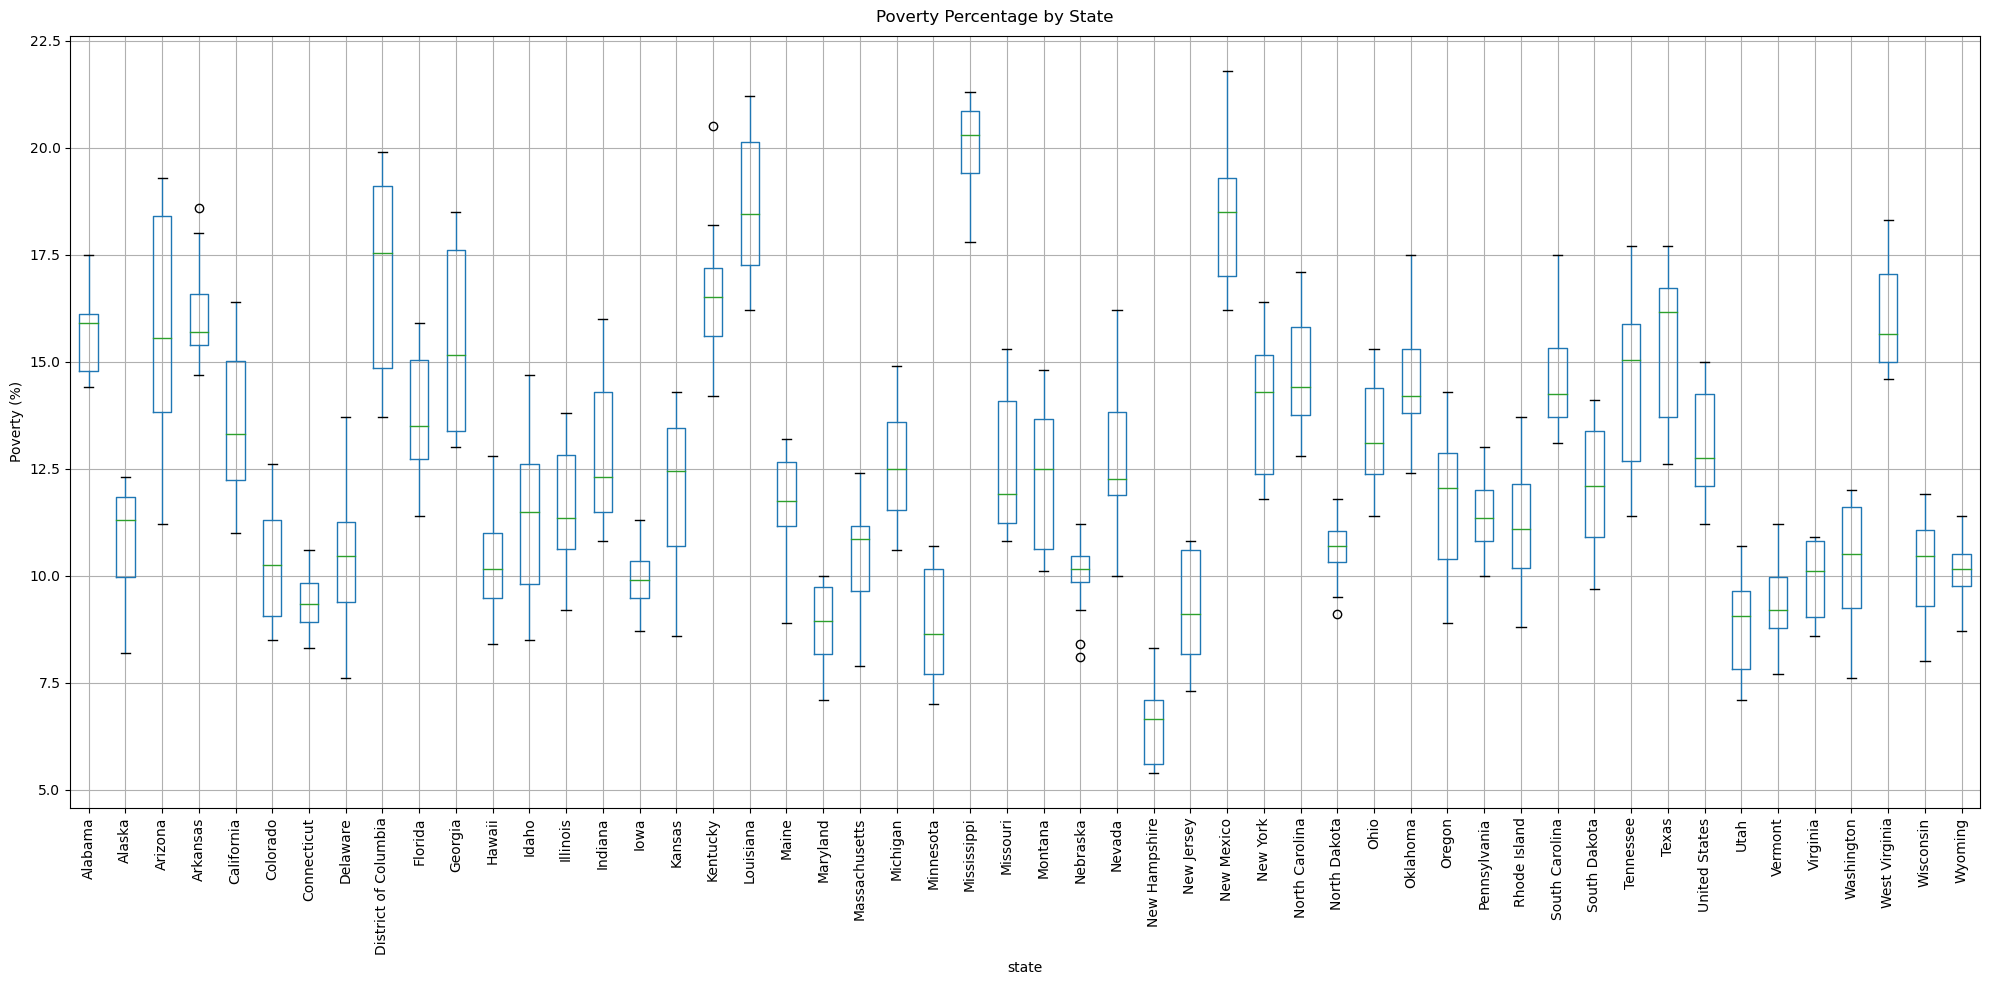

In [14]:
poverty_df.boxplot(column='povertyPercentage', by='state', figsize=(20, 10), rot=90, xlabel='state', ylabel='Poverty (%)')
plt.suptitle('Poverty Percentage by State')
plt.title('')
plt.tight_layout()

This plot shows that Arkansas, Kentucky, Nebraska and North Dakota seems to be affected by fliers. We check this by plotting their poverty percentage over the years.

Text(0.5, 1.0, 'Poverty (%) over the years')

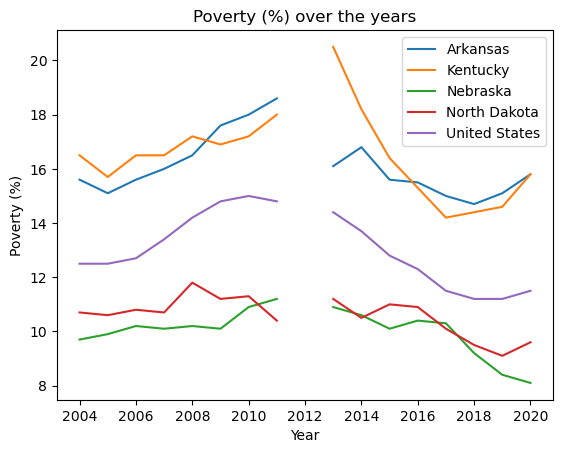

In [15]:
poverty_df[
    poverty_df['state'].isin(['Arkansas', 'Kentucky', 'Nebraska', 'North Dakota', 'United States'])
    ].pivot(index='year', columns='state', values='povertyPercentage').plot(kind='line')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Poverty (%)')
plt.title('Poverty (%) over the years')

The plot above shows that those fliers could be realistic values, we don't need to correct them.

Text(0.5, 1.0, 'Average poverty (%) over the years')

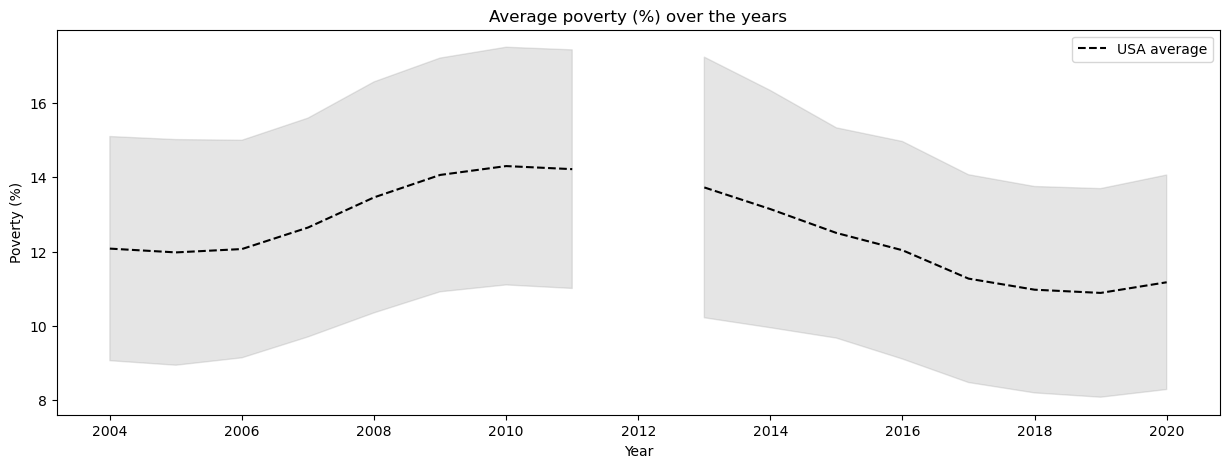

In [16]:
poverty_df.groupby('year')['povertyPercentage'].mean().plot(kind='line', figsize=(15, 5), label='USA average', color='black', style='--')
plt.fill_between(
    poverty_df.groupby('year')['povertyPercentage'].mean().index,
    poverty_df.groupby('year')['povertyPercentage'].mean() - poverty_df.groupby('year')['povertyPercentage'].std(),
    poverty_df.groupby('year')['povertyPercentage'].mean() + poverty_df.groupby('year')['povertyPercentage'].std(),
    alpha=0.2,
    color='gray'
)
plt.legend()
plt.xlabel('Year')
plt.ylabel('Poverty (%)')
plt.title('Average poverty (%) over the years')

We now plot the average poverty percentage over the years for each state:

Text(0, 0.5, 'Average Poverty (%)')

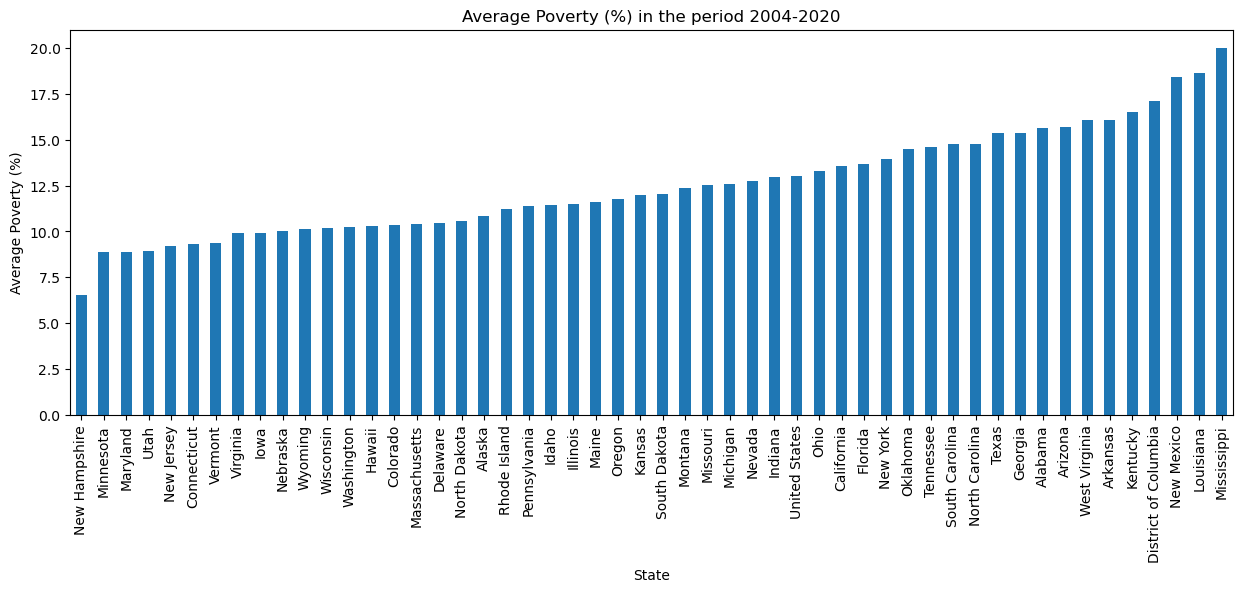

In [17]:
poverty_df.groupby(['state'])['povertyPercentage'].mean().sort_values().plot(kind='bar', figsize=(15, 5))
plt.title(f'Average Poverty (%) in the period {poverty_df.year.min()}-{poverty_df.year.max()}')
plt.xlabel('State')
plt.ylabel('Average Poverty (%)')

It is evident that New Hampshire's average poverty rate is markedly lower than that of the other states, whereas Mississippi's average poverty rate is notably higher than the rest. 

To inspect and compare the poverty percentage of each state over the year, we plot an interactive line chart:

In [18]:
fig = px.line(
    poverty_df.pivot(index='year', columns='state', values='povertyPercentage'),
    title='Poverty percentage in the US over the years')
fig.show()

We can oberserve that New Hampshire always had the lowest poverty percentage, whereas Mississippi had the highest till 2009, then it was surpassed by New Mexico and Louisiana.

To imputate the missing data from 2012, we calculate the average of the `povertyPercentage` values for the preceding and succeeding year.

In [19]:
poverty_perc_2012 = poverty_df[poverty_df['year'].isin([2011, 2013])].groupby(['state'])['povertyPercentage'].mean()
poverty_df['povertyPercentage'] = poverty_df.apply(
    lambda x: poverty_perc_2012[x['state']] if x['year']==2012 else x['povertyPercentage'], axis=1
)

Now we plot again the interactive line chart:

In [20]:
fig = px.line(
    poverty_df.pivot(index='year', columns='state', values='povertyPercentage'),
    title='Poverty percentage in the US over the years')
pyo.plot(fig, filename='../html/lines_poverty.html', auto_open=False)
fig.show()

We also visualize how the poverty percentage changed with an animated map (to do this we need the alphanumeric codes associated to each state):

In [23]:
usa_states_df = pd.read_csv(
    'https://www2.census.gov/geo/docs/reference/state.txt',
    sep='|',
    dtype={'STATE': str, 'STATE_NAME': str}
)
usa_name_alphcode = usa_states_df.set_index('STATE_NAME').to_dict()['STUSAB']
poverty_df.sort_values(by=['state', 'year'], inplace=True)
poverty_df['px_code'] = poverty_df['state'].map(usa_name_alphcode) # retrieve the code associated to each state (the map is defined in the file data_preparation_utils.py)
fig = px.choropleth(
    poverty_df[poverty_df['state']!='United States'],
    locations='px_code',
    locationmode="USA-states",
    color='povertyPercentage',
    color_continuous_scale="rdbu",
    range_color=(
        min(poverty_df[poverty_df['state']!='United States']['povertyPercentage']),
        max(poverty_df[poverty_df['state']!='United States']['povertyPercentage'])),
    scope="usa",
    animation_frame='year',
    title="US Poverty Percentage over the years",
    hover_name='state',
    hover_data={'px_code': False}
)
fig.update_layout(
    title_text='US Poverty Percentage over the years',
    coloraxis_colorbar_title_text = 'Poverty (%)'
)
pyo.plot(fig, filename='../html/animation_poverty.html', auto_open=False)
fig.show()

We write the cleaned dataset to a csv file:

In [22]:
poverty_df.to_csv('../data/poverty_by_state_year_cleaned.csv', index=False)